In [1]:
import librosa
import os
import json
import pickle
import zipfile
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization, ConvLSTM2D, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

In [2]:
paths = [os.path.join(dp, f) for dp, dn, fn in os.walk('train/audio') for f in fn if f[-4:]=='.wav']
paths = pd.DataFrame(paths, columns=['path']) # .sample(n=1000).reset_index(drop=True)
paths['label'] = paths['path'].apply(lambda x: x.split('/')[-2])
paths

,path,label
0,train/audio\bed\00176480_nohash_0.wav,train
1,train/audio\bed\004ae714_nohash_0.wav,train
2,train/audio\bed\004ae714_nohash_1.wav,train
3,train/audio\bed\00f0204f_nohash_0.wav,train
4,train/audio\bed\00f0204f_nohash_1.wav,train
...,...,...
64722,train/audio\_background_noise_\dude_miaowing.wav,train
64723,train/audio\_background_noise_\exercise_bike.wav,train
64724,train/audio\_background_noise_\pink_noise.wav,train
64725,train/audio\_background_noise_\running_tap.wav,train


In [3]:
def audio2mel(path):
    y, sr = librosa.core.load(path=path)
    if len(y) > sr: # we set all to have lenght equal to 1 second 
        y = y[:sr] 
    else: # pad blank
        padding = sr - len(y)
        offset = padding // 2 
        y = np.pad(y, (offset, sr - len(y) - offset), 'constant')
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return librosa.power_to_db(mel, ref= np.max).astype(np.float) 

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows(), total = df.shape[0]):
        x = audio2mel(row['path'])
        X.append(x.transpose())
    X = np.array(X) 
    return X
#os.chdir('/content/drive/MyDrive/DL3/')
if os.path.exists('X_train.npy') and os.path.exists('y_train.npy') and os.path.exists('class_names.npy'):
  X = np.load('X_train.npy', allow_pickle=True)
  y = np.load('y_train.npy', allow_pickle=True)
  classess = np.load('class_names.npy', allow_pickle=True)
else:
  X = convert_wav_to_image(paths)
  enc = OneHotEncoder() 
  y = enc.fit_transform(paths[['label']]).todense()
  classes = enc.get_feature_names()
  np.save('X_train.npy', X)
  np.save('y_train.npy', y)
  np.save('class_names.npy', classes)
X = (X - np.mean(X))/np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [5]:
model = Sequential()
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])

Epoch 1/30
949/949 [==============================] - 179s 172ms/step - loss: 2.0835 - accuracy: 0.3953 - val_loss: 0.6375 - val_accuracy: 0.8176
Epoch 2/30
949/949 [==============================] - 207s 218ms/step - loss: 0.6935 - accuracy: 0.8018 - val_loss: 0.4919 - val_accuracy: 0.8531
Epoch 3/30
949/949 [==============================] - 192s 202ms/step - loss: 0.4850 - accuracy: 0.8599 - val_loss: 0.3840 - val_accuracy: 0.8889
Epoch 4/30
949/949 [==============================] - 177s 186ms/step - loss: 0.3932 - accuracy: 0.8865 - val_loss: 0.3777 - val_accuracy: 0.8920
Epoch 5/30
949/949 [==============================] - 205s 216ms/step - loss: 0.3381 - accuracy: 0.9023 - val_loss: 0.3344 - val_accuracy: 0.9072
Epoch 6/30
949/949 [==============================] - 174s 184ms/step - loss: 0.2942 - accuracy: 0.9143 - val_loss: 0.2886 - val_accuracy: 0.9204
Epoch 7/30
949/949 [==============================] - 156s 165ms/step - loss: 0.2585 - accuracy: 0.9227 - val_loss: 0.3090 -

<AxesSubplot:>

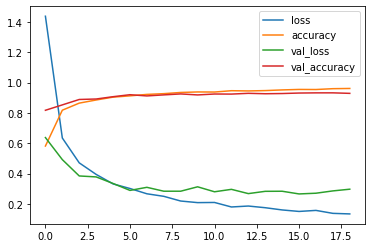

In [7]:
pd.DataFrame(history.history).plot()

In [8]:
def accuracy(model):
    p = model.predict(X_test)
    return np.mean(np.argmax(p,1) == np.argmax(y_test,1))
accuracy(model)

0.9318820224719101

Epoch 1/30
949/949 [==============================] - 740s 765ms/step - loss: 1.9593 - accuracy: 0.4408 - val_loss: 0.6088 - val_accuracy: 0.8232
Epoch 2/30
949/949 [==============================] - 777s 819ms/step - loss: 0.5850 - accuracy: 0.8308 - val_loss: 0.4324 - val_accuracy: 0.8767
Epoch 3/30
949/949 [==============================] - 768s 810ms/step - loss: 0.4296 - accuracy: 0.8770 - val_loss: 0.3886 - val_accuracy: 0.8861
Epoch 4/30
949/949 [==============================] - 755s 796ms/step - loss: 0.3311 - accuracy: 0.9028 - val_loss: 0.3611 - val_accuracy: 0.8944
Epoch 5/30
949/949 [==============================] - 748s 788ms/step - loss: 0.2919 - accuracy: 0.9143 - val_loss: 0.3143 - val_accuracy: 0.9132
Epoch 6/30
949/949 [==============================] - 747s 787ms/step - loss: 0.2563 - accuracy: 0.9262 - val_loss: 0.3232 - val_accuracy: 0.9085
Epoch 7/30
949/949 [==============================] - 740s 780ms/step - loss: 0.2314 - accuracy: 0.9291 - val_loss: 0.2749 -

0.9278089887640449

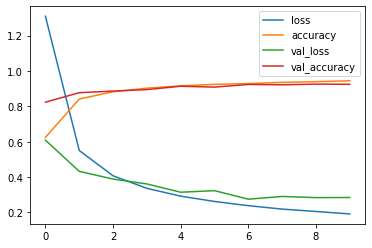

In [9]:
model2 = Sequential()
model2.add(BatchNormalization())
model2.add(Bidirectional(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
)))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(256, return_sequences=True)))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(512)))
model2.add(Dense(256))
model2.add(Dropout(0.5))
model2.add(Dense(y.shape[1]))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])

pd.DataFrame(history2.history).plot()

accuracy(model2)